In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
import sys
sys.path.insert(0,'/Users/eman/Documents/code_projects/kernellib/')

import matplotlib.pyplot as plt
%matplotlib inline

In [207]:
random_state = 0
rng = np.random.RandomState(random_state)

# Training data is 11 points in [0,1] inclusive regularly spaced# Traini 
x_train = np.linspace(0, 1, 25).reshape(-1, 1)

# True function is sin(2*pi*x) with Gaussian noise
y_train = np.sin(x_train * (4 * np.pi)) + rng.randn(x_train.shape[0], 1) * 0.3
y_train = np.squeeze(y_train)

x_test = np.linspace(0, 1, 1000).reshape(-1, 1)

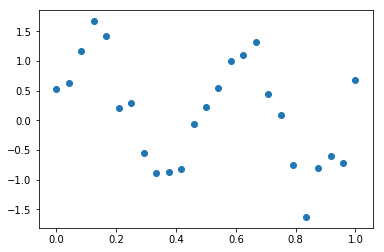

In [208]:
fig, ax = plt.subplots()

ax.scatter(x_train, y_train)

plt.show()

### RBF Kernel

In [209]:
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import euclidean_distances

def rbf_kernel(X, Y=None, gamma=None, scale=1.0):
    X, Y = check_pairwise_arrays(X, Y)
    
    if gamma is None:
        gamma = 1.0 / X.shape[1]

    K = euclidean_distances(X, Y, squared=True)
    K *= -gamma
    np.exp(K, K)    # exponentiate K in-place
    K *= scale

    return K

## KRR with Cross Validation

In [210]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.metrics.pairwise import check_pairwise_arrays
from sklearn.linear_model.ridge import _solve_cholesky_kernel
from sklearn.utils import check_array, check_X_y
from sklearn.utils.validation import check_is_fitted

class KernelRidge(BaseEstimator, RegressorMixin):
    """Kernel ridge regression.
    Kernel ridge regression (KRR) combines ridge regression (linear least
    squares with l2-norm regularization) with the kernel trick. It thus
    learns a linear function in the space induced by the respective kernel and
    the data. For non-linear kernels, this corresponds to a non-linear
    function in the original space.
    The form of the model learned by KRR is identical to support vector
    regression (SVR). However, different loss functions are used: KRR uses
    squared error loss while support vector regression uses epsilon-insensitive
    loss, both combined with l2 regularization. In contrast to SVR, fitting a
    KRR model can be done in closed-form and is typically faster for
    medium-sized datasets. On the other  hand, the learned model is non-sparse
    and thus slower than SVR, which learns a sparse model for epsilon > 0, at
    prediction-time.
    This estimator has built-in support for multi-variate regression
    (i.e., when y is a 2d-array of shape [n_samples, n_targets]).
    Read more in the :ref:`User Guide <kernel_ridge>`.
    Parameters
    ----------
    alpha : {float, array-like}, shape = [n_targets]
        Small positive values of alpha improve the conditioning of the problem
        and reduce the variance of the estimates.  Alpha corresponds to
        ``(2*C)^-1`` in other linear models such as LogisticRegression or
        LinearSVC. If an array is passed, penalties are assumed to be specific
        to the targets. Hence they must correspond in number.
    gamma : float, default=None
        Gamma parameter for the RBF, laplacian, polynomial, exponential chi2
        and sigmoid kernels. Interpretation of the default value is left to
        the kernel; see the documentation for sklearn.metrics.pairwise.
        Ignored by other kernels.
    scale : float, default=None
    
    Attributes
    ----------
    dual_coef_ : array, shape = [n_samples] or [n_samples, n_targets]
        Representation of weight vector(s) in kernel space
    X_fit_ : {array-like, sparse matrix}, shape = [n_samples, n_features]
        Training data, which is also required for prediction
    References
    ----------
    * Kevin P. Murphy
      "Machine Learning: A Probabilistic Perspective", The MIT Press
      chapter 14.4.3, pp. 492-493
    See also
    --------
    Ridge
        Linear ridge regression.
    SVR
        Support Vector Regression implemented using libsvm.
    Examples
    --------
    >>> from sklearn.kernel_ridge import KernelRidge
    >>> import numpy as np
    >>> n_samples, n_features = 10, 5
    >>> rng = np.random.RandomState(0)
    >>> y = rng.randn(n_samples)
    >>> X = rng.randn(n_samples, n_features)
    >>> clf = KernelRidge(alpha=1.0)
    >>> clf.fit(X, y) # doctest: +NORMALIZE_WHITESPACE
    KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear',
                kernel_params=None)
    """
    def __init__(self, alpha=1, kernel="linear", gamma=1.0, scale=1.0):
        self.alpha = alpha
        self.kernel = kernel
        self.gamma = gamma
        self.scale = scale

    def fit(self, X, y=None, sample_weight=None):
        """Fit Kernel Ridge regression model
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training data
        y : array-like, shape = [n_samples] or [n_samples, n_targets]
            Target values
        sample_weight : float or array-like of shape [n_samples]
            Individual weights for each sample, ignored if None is passed.
        Returns
        -------
        self : returns an instance of self.
        """
        # Convert data
        X, y = check_X_y(X, y, accept_sparse=("csr", "csc"), multi_output=True,
                         y_numeric=True)

        K = rbf_kernel(X, gamma=self.gamma, scale=self.scale)
        alpha = np.atleast_1d(self.alpha)

        ravel = False
        if len(y.shape) == 1:
            y = y.reshape(-1, 1)
            ravel = True

        copy = self.kernel == "precomputed"
        self.dual_coef_ = _solve_cholesky_kernel(K, y, alpha,
                                                 sample_weight,
                                                 copy)
        if ravel:
            self.dual_coef_ = self.dual_coef_.ravel()

        self.X_fit_ = X

        return self

    def predict(self, X):
        """Predict using the kernel ridge model
        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Samples.
        Returns
        -------
        C : array, shape = [n_samples] or [n_samples, n_targets]
            Returns predicted values.
        """
        check_is_fitted(self, ["X_fit_", "dual_coef_"])
        K = rbf_kernel(X, self.X_fit_, gamma=self.gamma, scale=self.scale)
        return np.dot(K, self.dual_coef_)

In [211]:
from sklearn.model_selection import GridSearchCV

In [212]:
print(np.logspace(0, 10, 10))

[1.00000000e+00 1.29154967e+01 1.66810054e+02 2.15443469e+03
 2.78255940e+04 3.59381366e+05 4.64158883e+06 5.99484250e+07
 7.74263683e+08 1.00000000e+10]


In [213]:
%%time
krr_grid = GridSearchCV(KernelRidge(kernel='rbf'), cv=2, n_jobs=2,
                  param_grid={"alpha": [1e0, 0.1, 1e-2, 1e-3],
                              "gamma": np.logspace(-3, 3, 20),
                              "scale": np.logspace(-3, 3, 20)})
krr_grid.fit(x_train, y_train)
krr_model = krr_grid.best_estimator_

print(krr_model.scale, krr_model.gamma, krr_model.alpha)

scale = krr_model.scale
gamma = krr_model.gamma
length_scale = 1 / np.sqrt(2 * gamma)
alpha = krr_model.alpha

2.976351441631316 12.742749857031322 0.001
CPU times: user 445 ms, sys: 24 ms, total: 469 ms
Wall time: 1.52 s


In [214]:
# scale = 0.613**2
# length_scale = 0.2
# gamma = 1 / (2 * length_scale**2)
# alpha = 0.228
scale = krr_model.scale
gamma = krr_model.gamma
length_scale = 1 / np.sqrt(2 * gamma)
alpha = krr_model.alpha

krr_model = KernelRidge(kernel='rbf', gamma=gamma, alpha=alpha, scale=scale)

krr_model.fit(x_train, y_train);

print(krr_model)

KernelRidge(alpha=0.001, gamma=12.742749857031322, kernel='rbf',
      scale=2.976351441631316)


### RBF Derivative

[Nx dx] = size(x);
[Ns ds] = size(sv);
Kreg = kernel2(x,sv,sigma);
% for p=1:Nx
%     for q=1:Ns
%         for xxx = 1:dx
%             map0(xxx,p,q) = alpha(q) * (x(p,xxx)-sv(q,xxx)) * Kreg(p,q);
%         end
%     end
% end

map2 = zeros(dx,Nx,Ns);
for p=1:Nx
        map2(:,p,:) = (repmat(alpha,1,size(sv,2)) .* (repmat(x(p,:),size(sv,1),1)-sv) .* repmat(Kreg(p,:)',1,size(sv,2)))';
        %p
end

In [215]:
import sys
sys.path.insert(0, '/home/emmanuel/Drives/erc/code/kernellib')

from kernellib.derivatives import ard_derivative

In [216]:
def rbf_derivative(x_train, x_function, weights, gamma, scale):
    if np.ndim(x_function) == 1:
        x_function = x_function[np.newaxis, :]
    if np.ndim(weights) == 1:
        weights = weights[:, np.newaxis]
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    K = rbf_kernel(x_function, x_train, gamma=gamma, scale=scale)
    constant = -2*gamma
    
    for itest in range(n_test):
        term1 = (np.tile(x_function[itest, :], (n_train, 1)) - x_train)
        term2 = np.tile(weights, (1, d_dims))
        term3 = np.tile(K[itest, :].T, (1, d_dims)).T
        derivative[itest, :, :] = term1 * term2 * term3\

    derivative *= constant
    derivative = np.sum(derivative, axis=1)
    return derivative

def rbf_derivative_loops(x_train, x_function, weights, gamma, scale):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    K = rbf_kernel(x_function, x_train, gamma=gamma, scale=scale)
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = - 2* gamma
    for itest in range(n_test):
        for itrain in range(n_train):
            for idim in range(d_dims):
                derivative[itest, itrain, idim] = \
                    weights[itrain] \
                    * (x_function[itest, idim] - x_train[itrain, idim]) \
                    * K[itest, itrain]
    
    derivative *= constant
    derivative = np.sum(derivative, axis=1)
    return derivative

def rbf_derivative_loops2(x_train, x_function, weights, gamma, scale):
    
    n_test, d_dims = x_function.shape
    n_train, d_dims = x_train.shape
    K = rbf_kernel(x_function, x_train, gamma=gamma, scale=scale)
    
    derivative = np.zeros(shape=(n_test, n_train, d_dims))
    
    constant = 2 * gamma
    for itest in range(n_test):
        for itrain in range(n_train):
            for idim in range(d_dims):
                derivative[itest, itrain, idim] = constant *\
                     (constant * (x_function[itest, idim] - x_train[itrain, idim])**2 - 1) \
                    * K[itest, itrain] * weights[itrain]
    
    derivative = np.sum(derivative, axis=1)
    return derivative

In [217]:
y_pred = krr_model.predict(x_test)

d1 = rbf_derivative(x_train, x_test, krr_model.dual_coef_, gamma, scale)


### Numerical Gradient

In [218]:
def np_gradient(x_test, n_points=1000):
    xt = np.linspace(x_test.min(), x_test.max(), n_points)
    y_pred = krr_model.predict(xt[:, np.newaxis])
    return np.gradient(y_pred, xt)[:, np.newaxis]

### Accuracy Test

In [219]:
%%time
print(length_scale, gamma)
d1 = rbf_derivative(x_train, x_test, krr_model.dual_coef_, gamma, scale)
d2 = rbf_derivative_loops(x_train, x_test, krr_model.dual_coef_, gamma, scale)
d3 = ard_derivative(x_train, x_test, krr_model.dual_coef_, length_scale, scale)
d4 = np_gradient(x_test, n_points=1000)
np.testing.assert_array_almost_equal(d1, d2)
np.testing.assert_array_almost_equal(d3, d2)

# omit the parts in the middle which are determined by the boundaries
# only works up to 3 decimal places
np.testing.assert_array_almost_equal(d1[1:-1], d4[1:-1], decimal=3)

0.1980858362366505 12.742749857031322
CPU times: user 277 ms, sys: 52 µs, total: 277 ms
Wall time: 71.1 ms


#### Speed Test

In [204]:
print('Speed for derivative with loops:')
%timeit rbf_derivative_loops(x_train, x_test, krr_model.dual_coef_, gamma, scale)

print('\nSpeed for fast derivative with tiling:')
%timeit rbf_derivative(x_train, x_test, krr_model.dual_coef_, gamma, scale)

print('\nSpeed with fast ARD kernel:')
%timeit ard_derivative(x_train, x_test, krr_model.dual_coef_, length_scale, scale)

Speed for derivative with loops:
20.2 ms ± 201 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Speed for fast derivative with tiling:
13.1 ms ± 272 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

Speed with fast ARD kernel:
4.44 ms ± 35.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


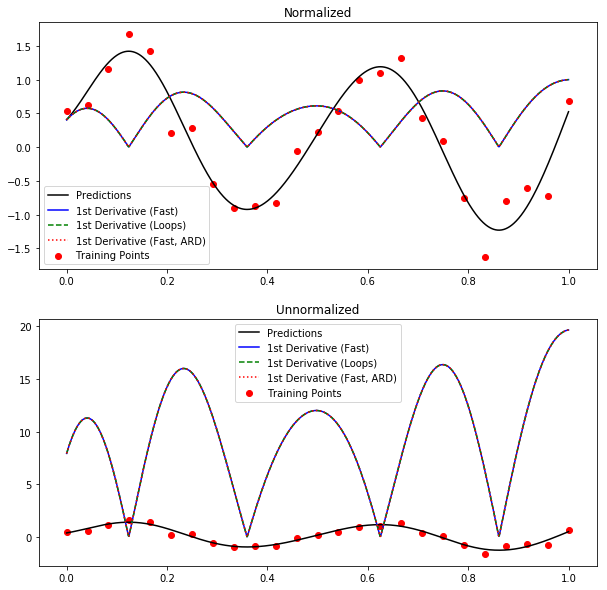

In [205]:
fig, ax = plt.subplots(nrows=2, figsize=(10,10))

ax[0].scatter(x_train, y_train, color='r', label='Training Points')
ax[0].plot(x_test, y_pred, color='k', label='Predictions')
ax[0].plot(x_test, np.abs(d1)/d1.max(), color='b', linestyle='-', label='1st Derivative (Fast)')
ax[0].plot(x_test, np.abs(d2)/d2.max(), color='g', linestyle='--', label='1st Derivative (Loops)')
ax[0].plot(x_test, np.abs(d3)/d3.max(), color='r', linestyle=':', label='1st Derivative (Fast, ARD)')

ax[0].set_title('Normalized')
ax[0].legend()

ax[1].scatter(x_train, y_train, color='r', label='Training Points')
ax[1].plot(x_test, y_pred, color='k', label='Predictions')
ax[1].plot(x_test, np.abs(d1), color='b', linestyle='-', label='1st Derivative (Fast)')
ax[1].plot(x_test, np.abs(d2), color='g', linestyle='--', label='1st Derivative (Loops)')
ax[1].plot(x_test, np.abs(d3), color='r', linestyle=':', label='1st Derivative (Fast, ARD)')

ax[1].set_title('Unnormalized')
ax[1].legend()
plt.show()

In [169]:
def f_approx(y_pred):
    h = 0.00001
    
    # initialize matrix
    ader = np.zeros_like(y_pred)
    #  second order central difference
    ader[1:-1] = (y_pred[2:] + 2 * y_pred[1:-1] - y_pred[:-2])/(h**2) # second order central difference
    
    # Boundary - forward difference
    ader[0] = (y_pred[0] + y_pred[1])/h    # forward difference 
    
    # Boundary - backwards difference
    ader[-1] = (y_pred[-1] - y_pred[-2])/h # backward difference
    return ader
xt = np.linspace(x_test.min(), x_test.max(), 10000)


ValueError: when 1d, distances must match the length of the corresponding dimension

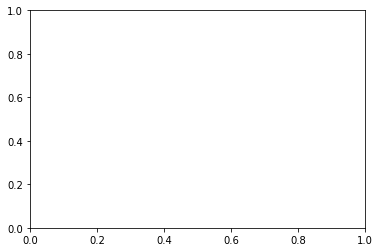

In [170]:
fig, ax = plt.subplots(nrows=1)


fd_der = f_approx(y_pred.squeeze())
grad_der = np_gradient(y_pred.squeeze(), xt)
my_der = rbf_derivative_loops(x_train, x_test, krr_model.dual_coef_, gamma, scale)

ax.scatter(x_train, y_train, color='r', label='Training Points')
ax.plot(x_test, y_pred, color='k', label='Predictions')
ax.plot(x_test, my_der, color='b', label='Derivative (RBF)')
ax.plot(x_test, grad_der, color='orange', label='Derivative (Gradient)')

# ax.plot(x_test, fd_der, color='g', label='Derivative (Finite Difference)')

ax.legend()
plt.show()

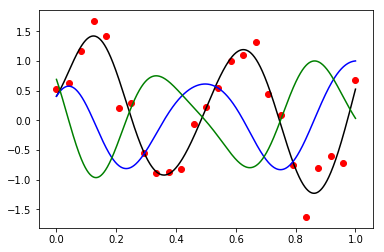

In [168]:
fig, ax = plt.subplots(nrows=1)

d11 = rbf_derivative_loops(x_train, x_test, krr_model.dual_coef_, gamma, scale)
d22 = rbf_derivative_loops2(x_train, x_test, krr_model.dual_coef_, gamma, scale)

ax.scatter(x_train, y_train, color='r', label='Training Points')
ax.plot(x_test, y_pred, color='k', label='Predictions')
ax.plot(x_test, d11/d11.max(), color='b', label='1st Derivative (Loops)')
ax.plot(x_test, d22/d22.max(), color='g', label='2nd Derivative (Loops)')

plt.show()

### Checking the Derivatives


N = 1000;
Ntest = 100;
noise_lev = 0;

sigma = 10;

%
x = randn(2,N);
%y = sin(3*x)+0.2*randn(size(x));
y = x(1,:).^2 + x(2,:).^2 + noise_lev*randn(1,N);
y = y -mean(y);

x2 = linspace(min(x),max(x),Ntest);% y2 = D2(ii(1:20),2);

%% model training

K = kernel2(x',x',sigma);
alphas = inv(K+0.01*eye(size(x,2)))*y';

%%

for ii=1:size(x2,2)
    [d(ii) dy(ii) dh(ii)]  = checkgrad('apply_gps_val', x2(ii), 1e-8, x, alphas, sigma);
end

figure
plot(dy,dh,'.')


%%

pf_px = pf_px_val(x2(ii)',x',alphas,sigma);

[pf2_px map] = pf2_px_val(x2(ii),x',alphas,sigma);

[pf_px pf2_px] = apply_gps_val(x,sv,alphas,sigma);

figure
plot(dy-dh,'.')

#### Finite Difference Approximation

In [79]:
print(x_test.shape)
fd_derivative = f_approx(x_test, krr_model.predict)

(100, 1)


ValueError: Incompatible dimension for X and Y matrices: X.shape[1] == 1 while Y.shape[1] == 2

In [70]:
from scipy.optimize import check_grad
from scipy.optimize import approx_fprime

In [71]:
n_train, n_test = 1000, 100
sigma = 10
sigmay = 0.0
scale = 1.0

x = rng.randn(n_train, 2)
y = x[:, 0]**2 + x[:, 1]**2 + sigmay * rng.randn(n_train)
y -= np.mean(y)

xt = np.linspace(x.min(), x.max(), n_test)[:, np.newaxis]
xt = np.hstack([xt, xt])
print(x.shape, xt.shape)

(1000, 2) (100, 2)


In [72]:
# Train the Model
krr_model = KernelRidge(kernel='rbf', gamma=1/(2*sigma**2), alpha=0.01, scale=scale)

krr_model.fit(x, y);

weights = krr_model.dual_coef_
gamma = krr_model.gamma
scale = krr_model.scale

In [73]:


def func(x_test):
    return krr_model.predict(x_test)

def my_grad(x_test):
#     return rbf_derivative(x, x_test, weights, gamma, scale) 
    return rbf_derivative_loops(x, x_test, weights, gamma, scale)
#     return ard_derivative(x, x_test, krr_model.dual_coef_, length_scale, scale)

def f_approx(y_pred):
    h = 0.1
    ader = np.zeros_like(x_test)
    print(ader.shape)
    ader[1:-1] = (y_pred[2:] + 2 * y_pred[1:-1] - y_pred[:-2])/(h**2) # second order central difference
    ader[0] = (y_pred[0] + y_pred[1])/h    # forward difference 
    ader[-1] = (y_pred[-1] - y_pred[-2])/h # backward difference
    return ader

eps = np.sqrt(np.finfo(float).eps)
# eps = [np.sqrt(200) * eps]
approx_der = np.empty_like(xt)
fd_der = np.empty_like(xt)
myder = np.copy(approx_der)
errors = np.copy(approx_der)

for i in range(len(xt)):
    point = xt[i, :]
    if np.ndim(point) == 1:
        point = point[np.newaxis, :]
    errors[i] = check_grad(func, my_grad, x0=point)
    approx_der[i] = approx_fprime(point, func, epsilon=eps)
    fd_der[i] = f_approx()
    myder[i] = my_grad(point)

print(errors[i], approx_der[i], myder[i])

[4.78515602 4.73203013] [9.5171895 9.5171895] [4.73203348 4.78515937]


(100, 2) (100, 2) (100, 2) (100, 2)


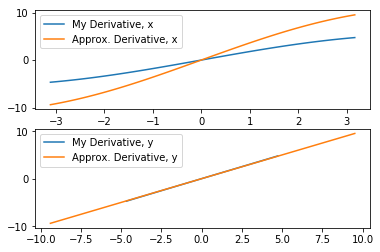

In [25]:
print(xt.shape, errors.shape, approx_der.shape, myder.shape)
fig, ax = plt.subplots(nrows=2)

ax[0].plot(xt[:, 0], myder[:, 0], label='My Derivative, x')
ax[1].plot(myder[:, 0], myder[:, 1], label='My Derivative, y')

# ax.plot(xt, errors)
ax[0].plot(xt[:, 0], approx_der[:, 0], label='Approx. Derivative, x')
ax[1].plot(approx_der[:, 0], approx_der[:, 1], label='Approx. Derivative, y')
ax[0].legend()
ax[1].legend()

plt.show()

In [677]:
def func(x_test):
    return krr_model.predict(x_test)

def my_grad(x_test):
    return rbf_derivative(x_train, x_test, krr_model.dual_coef_, gamma, scale)
def f_approx(x_test):
    h = 0.1
    ader = np.zeros_like(x_test)
    print(ader.shape)
    ader[1:-1] = (x_test[2:] + 2 * x_test[x_test[:-2])/(2*h) # central difference
    ader[0] = (x_test[0] + x_test[1])/h    # forward difference 
    ader[-1] = (x_test[-1] - x_test[-2])/h # backward difference
    return ader

fdiff = f_approx(x_test)

# check_grad(func, npgrad, x_test)

(51, 1)


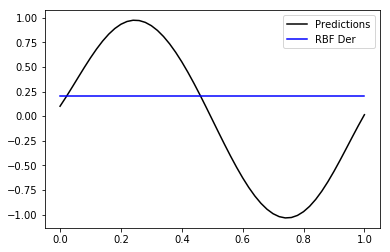

In [678]:
fig, ax = plt.subplots()

ax.plot(x_test, y_pred, color='k', label='Predictions')
# ax.plot(x_test, der, color='b', label='RBF Der')
ax.plot(x_test, fdiff, color='b', label='RBF Der')

ax.legend()
plt.show()